In [9]:
import matplotlib.pyplot as plt
import numpy as np
import qutip_qip
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay,
                   sigmaz, tensor)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
from qutip_qip.operations import Gate
from scipy.optimize import curve_fit

In [28]:
with open("rename.py") as f:
    exec(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'rename.py'

In [30]:
def single_crosstalk_simulation(num_gates):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    # Qubit-0 is the target qubit. Qubit-1 suffers from crosstalk.
    num_qubits = 2
    myprocessor = ModelProcessor(model=MyModel(num_qubits))
    # Add qubit frequency detuning 1.852MHz for the second qubit.
    myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = MyCompiler(num_qubits,
                            {"pulse_amplitude": 0.02, "duration": 25})
    myprocessor.add_noise(ClassicalCrossTalk(1.0))
    # Define a randome circuit.
    gates_set = [
        Gate("ROT", 0, arg_value=0),
        Gate("ROT", 0, arg_value=np.pi / 2),
        Gate("ROT", 0, arg_value=np.pi),
        Gate("ROT", 0, arg_value=np.pi / 2 * 3),
    ]
    circuit = QubitCircuit(num_qubits)
    for ind in np.random.randint(0, 4, num_gates):
        circuit.add_gate(gates_set[ind])
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    init_state = tensor(
        [Qobj([[init_fid, 0], [0, 0.025]]),
         Qobj([[init_fid, 0], [0, 0.025]])]
    )
    # increase the maximal allowed steps
    options = Options(nsteps=10000)
    e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

    # compute results of the run using a solver of choice
    result = myprocessor.run_state(
        init_state, solver="mesolve", options=options, e_ops=e_ops
    )
    # measured expectation value at the end
    result = result.expect[0][-1]
    return result


# The full simulation may take several hours
# so we just choose num_sample=2 and num_gates=250 as a test
num_sample = 2
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [250]

# The full simulation is defined in the commented lines below.

# from joblib import Parallel, delayed  # for parallel simulations
# num_sample = 1600
# num_gates_list = [250, 500, 750, 1000, 1250, 1500]

for num_gates in num_gates_list:
    expect = [single_crosstalk_simulation(num_gates)
              for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect) / np.sqrt(num_sample))

TypeError: 'int' object is not subscriptable

In [10]:
class MyModel(Model):
    def __init__(
        self, num_qubits, dims=None):
        super().__init__(num_qubits, dims=dims)
        # Control Hamiltonians
        self.controls = {}
        self.controls.update(
            {"sx0": (2 * np.pi * sigmax(),0)}
        )
        self.controls.update(
            {"sy0": (2 * np.pi * sigmay(),0)}
        ),

    def get_control(self, label):
        """
        The mandatory method. It Returns a pair of Qobj and int representing
        the control Hamiltonian and the target qubit.
        """
        return self.controls[label]

    def get_control_labels(self):
        """
        It returns all the labels of availble controls.
        """
        return self.controls.keys()

In [11]:
model=MyModel(1)
model.get_control("sx0")

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.         6.28318531]
  [6.28318531 0.        ]],
 0)

In [12]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
            "XPulse": self.super_conducting_compiler,
            "YPulse":self.super_conducting_compiler,
            "XHalfPulse":self.super_conducting_compiler,
            "YHalfPulse":self.super_conducting_compiler,
            "XHalfMinusPulse":self.super_conducting_compiler,
            "YHalfMinusPulse":self.super_conducting_compiler
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)
    
    def super_conducting_compiler(self,gate,args):
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)

In [16]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

def original_Hamiltonian(t, phiNaught, N=None, target=0):
    """Single-qubit evolution.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    phi = phiNaught + np.random.normal(scale=phaseStd)
    I = np.cos(phi)
    Q = np.sin(phi)

    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    H = omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
    return Qobj(H/(1j* hbar), dims=[[2], [2]])

### Define half-pulse gate

In [42]:
def X_half_gate(phi, N=None, target=0):
     """Single-qubit rotation for operator sigmax with angle phi.

     Returns
     -------
     result : qobj
          Quantum object for operator describing the rotation.

     """
     if N is not None:
          return gate_expand_1toN(rx(phi), N, target)
     else:
          return Qobj(   [[np.cos(phi / 2), -1j * np.sin(phi / 2)],
                         [-1j * np.sin(phi / 2), np.cos(phi / 2)]])

def X_minus_half_gate(phi, N=None, target=0):
     """Single-qubit rotation for operator sigmax with angle phi.

     Returns
     -------
     result : qobj
          Quantum object for operator describing the rotation.

     """
     if N is not None:
          return gate_expand_1toN(rx(phi), N, target)
     else:
          return Qobj(   [[np.cos(phi / 2), -1j * np.sin(phi / 2)],
                         [-1j * np.sin(phi / 2), np.cos(phi / 2)]])
     
def Y_half_gate(phi, N=None, target=0):
    """Single-qubit rotation for operator sigmay with angle phi.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    if N is not None:
        return gate_expand_1toN(ry(phi), N, target)
    else:
        return Qobj([[np.cos(phi / 2), -np.sin(phi / 2)],
                     [np.sin(phi / 2), np.cos(phi / 2)]])

def Y_minus_half_gate(phi, N=None, target=0):
    """Single-qubit rotation for operator sigmay with angle phi.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    if N is not None:
        return gate_expand_1toN(ry(phi), N, target)
    else:
        return Qobj([[np.cos(phi / 2), -np.sin(phi / 2)],
                     [np.sin(phi / 2), np.cos(phi / 2)]])

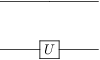

In [43]:
qc = QubitCircuit(2)
qc.user_gates = {"RX_half": X_half_gate,
                 "RY_half": Y_half_gate,
                 "RX_minus_half": X_minus_half_gate,
                 "RY_minus_half": Y_minus_half_gate
                }
qc.add_gate("RY_half", targets=0, arg_value=np.pi / 2)
qc

In [26]:
pi_pulse_duration = 4.7959183673469386e-08
pi_half_pulse_duration = 2.3979591836734693e-08
t_0 = 0
t_final = pi_pulse_duration

In [29]:
# The full simulation may take several hours
num_sample = 10
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [25, 50, 75, 100, 125, 150]

# The full simulation is defined in the commented lines below.
# from joblib import Parallel, delayed  # for parallel simulations
# num_sample = 1600
# num_gates_list = [250, 500, 750, 1000, 1250, 1500]

for num_gates in num_gates_list:
    expect = [single_crosstalk_simulation(num_gates) for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect) / np.sqrt(num_sample))

NameError: name 'sigma_x' is not defined

In [13]:
# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(1)
circuit.add_gate("RX", targets=0, arg_value=np.pi / 2)
circuit.add_gate("Z", targets=0)

In [14]:
myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX", "RY"]

mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_8964\2918505178.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


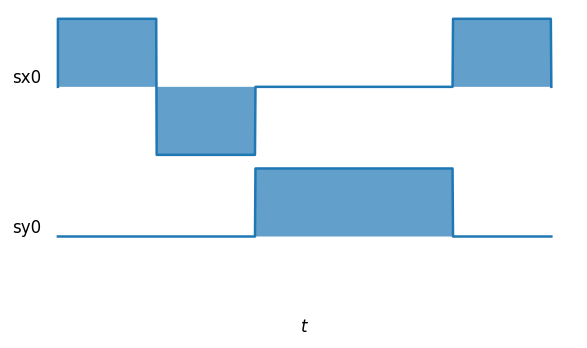

In [15]:
fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120,
                                  use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

In [45]:
def X_half_gate(phi, N=None, target=0):
     """Single-qubit rotation for operator sigmax with angle phi.

     Returns
     -------
     result : qobj
          Quantum object for operator describing the rotation.

     """
     if N is not None:
          return gate_expand_1toN(rx(phi), N, target)
     else:
          return Qobj(   [[np.cos(phi / 2), -1j * np.sin(phi / 2)],
                         [-1j * np.sin(phi / 2), np.cos(phi / 2)]])

def X_minus_half_gate(phi, N=None, target=0):
     """Single-qubit rotation for operator sigmax with angle phi.

     Returns
     -------
     result : qobj
          Quantum object for operator describing the rotation.

     """
     if N is not None:
          return gate_expand_1toN(rx(phi), N, target)
     else:
          return Qobj(   [[np.cos(phi / 2), -1j * np.sin(phi / 2)],
                         [-1j * np.sin(phi / 2), np.cos(phi / 2)]])
     
def Y_half_gate(phi, N=None, target=0):
    """Single-qubit rotation for operator sigmay with angle phi.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    if N is not None:
        return gate_expand_1toN(ry(phi), N, target)
    else:
        return Qobj([[np.cos(phi / 2), -np.sin(phi / 2)],
                     [np.sin(phi / 2), np.cos(phi / 2)]])

def Y_minus_half_gate(phi, N=None, target=0):
    """Single-qubit rotation for operator sigmay with angle phi.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    if N is not None:
        return gate_expand_1toN(ry(phi), N, target)
    else:
        return Qobj([[np.cos(phi / 2), -np.sin(phi / 2)],
                     [np.sin(phi / 2), np.cos(phi / 2)]])

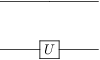

In [ ]:
qc = QubitCircuit(2)
qc.user_gates = {"RX_half": X_half_gate,
                 "RY_half": Y_half_gate,
                 "RX_minus_half": X_minus_half_gate,
                 "RY_minus_half": Y_minus_half_gate
                }
qc.add_gate("RY_half", targets=0, arg_value=np.pi / 2)
qc

In [49]:
num_gates = 25

In [50]:
num_qubits = 2
myprocessor = ModelProcessor(model=MyModel(num_qubits))
# Add qubit frequency detuning 1.852MHz for the second qubit.
myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
myprocessor.native_gates = None  # Remove the native gates
mycompiler = MyCompiler(num_qubits,
                        {"pulse_amplitude": 0.02, "duration": 25})
myprocessor.add_noise(ClassicalCrossTalk(1.0))
# Define a randome circuit.
gates_set = [
    Gate("ROT", 0, arg_value=0),
    Gate("ROT", 0, arg_value=np.pi / 2),
    Gate("ROT", 0, arg_value=np.pi),
    Gate("ROT", 0, arg_value=np.pi / 2 * 3),
]
circuit = QubitCircuit(num_qubits)
for ind in np.random.randint(0, 4, num_gates):
    circuit.add_gate(gates_set[ind])
# Simulate the circuit.
myprocessor.load_circuit(circuit, compiler=mycompiler)
init_state = tensor(
    [Qobj([[init_fid, 0], [0, 0.025]]),
        Qobj([[init_fid, 0], [0, 0.025]])]
)
# increase the maximal allowed steps
options = Options(nsteps=10000)
e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

# compute results of the run using a solver of choice
result = myprocessor.run_state(init_state, solver="mesolve", options=options, e_ops=e_ops)
# measured expectation value at the end
result = result.expect[0][-1]

TypeError: 'int' object is not subscriptable